In [2]:
%matplotlib inline
import sys
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")

import matplotlib.pyplot as plt
import numpy as np

from icglm.iclamp import IClamp
# from icglm.kernels import KernelRect
# from icglm.processes import GeneralCov, OUProcess

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading and preprocessing patch clamp data

(<Figure size 864x360 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f819718b588>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f8196e8cf28>))

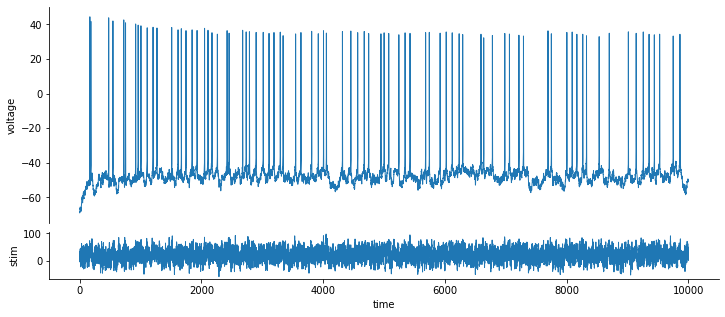

In [3]:
ic = IClamp.load_from_abf(path='./18o03049.abf')
ic = ic.subtract_Ih(th=1000.1).restrict(t0=1000.1, tf=11000.1)
ic.plot(sweeps=[0])

### Fitting encoding GLM to data

In [4]:
from icglm.glm_fitting import GLMFitter
glm_fit = GLMFitter(ic).set_mask_spikes(thr=-13).subsample(10)

tbins_kappa = np.arange(0, 220, 5)
tbins_eta = np.arange(0, 480, 10)

glm_fit.fit(tbins_kappa=tbins_kappa, tbins_eta=tbins_eta)
glm_fit.plot_filters()

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [ ]:
from icglm.kernels import KernelFun
glm_fit.set_mask_spikes_model(trials=9)
glm_fit.psth(psth_kernel=KernelFun.gaussian_delta(delta=40))
glm_fit.plot_raster()

### Decoding stimulus from spike data and GLM

In [ ]:
from icglm.glm_decoding import GLMDecoder
Imu, Isd = np.mean(glm_fit.ic.stim), np.mean(np.std(glm_fit.ic.stim, 0))
I0 = np.zeros(len(glm_fit.ic.t))
decoder = GLMDecoder(glms=[glm_fit.glm], t=glm_fit.ic.t, mask_spk=[glm_fit.mask_spikes], 
                     tau=3, Imu=[Imu], Isd=[Isd], I_true=(glm_fit.ic.stim - Imu) / Isd)
decoder.estimate_MAP_I(I0, prior='OU')
decoder.plot_decoded_stimulus(t0=4000, tf=6500)